Variational Auto-Encoders
=========================
This code implements a Variation Auto-Encoder (VAE). If using Google Colab, please activate the use of the GPU (Edit -> Notebok Settings).

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    !pip3 install torch torchvision #--index-url https://download.pytorch.org/whl/cu118 #uncomment to enforce cuda 11.8

if 'google.colab' in sys.modules and 'tqdm' not in sys.modules:
    !pip3 install tqdm


%matplotlib inline
import os
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from matplotlib import gridspec

import os
if os.path.exists('./training') == False:
  os.mkdir('./training')

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

Hyper-Parameters
----------------

In [13]:
batch_size = 3000     # batch size
latent_dim = 600      # latent-space dimension
middle_dim = 300      # size of the middle layer
learning_rate = 1e-3  # learning rate
max_epochs = 100       # maximum number of epochs
use_gpu = True        # using the GPU

Loading the Dataset
-------------------
As in the GAN example, we will be using the MNIST dataset. MNIST images show digits from 0-9 in 28x28 grayscale images.

In [14]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.ToTensor()

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# image dimensions
input_dim = 28**2

VAE Definition
--------------
We will now use a specific scheme to initialize our weights, called Xavier initialization. You can neglect this if you are using other layers than fully connected.

In [15]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

The following model represents the distribution encoder distribution q(z|x), together with the reparametrization trick.

In [16]:
class Q(nn.Module):
  def __init__(self, input_dim, middle_dim, latent_dim):
    super(Q, self).__init__()
    self.lin_middle = nn.Linear(input_dim, middle_dim, bias=True)
    self.lin_mu = nn.Linear(middle_dim, latent_dim, bias=True)
    self.lin_var = nn.Linear(middle_dim, latent_dim, bias=True)

    # Xavier initialization (to be neglected if using other than fully-connected)
    init_weights(self.lin_middle)
    init_weights(self.lin_mu)
    init_weights(self.lin_var)

  def forward(self, input):
    # forward
    middle = F.relu(self.lin_middle(input))
    z_mu = self.lin_mu(middle)
    z_var = self.lin_var(middle)
    return z_mu, z_var

We now model the reparametrization trick.

In [17]:
class Reparametrization(nn.Module):
  def __init__(self):
    super(Reparametrization, self).__init__()

  def forward(self, z_mu, z_var):
    eps = torch.randn(z_var.size(0), z_var.size(1), device=device) # sample on a unit Gaussian
    return z_mu + torch.exp(z_var/2) * eps

The following model represents the decoder P(x|z).

In [18]:
class P(nn.Module):
  def __init__(self, input_dim, middle_dim, latent_dim):
    super(P, self).__init__()
    self.lin_latent = nn.Linear(latent_dim, middle_dim, bias=True)
    self.lin_middle = nn.Linear(middle_dim, input_dim, bias=True)

    # Xavier initialization (to be neglected if using other than fully-connected)
    init_weights(self.lin_latent)
    init_weights(self.lin_middle)

  def forward(self, latent):
    middle = F.relu(self.lin_latent(latent))
    return F.sigmoid(self.lin_middle(middle))

Training
--------

We first initialize an instance of the model and load it onto GPU if relevant.

In [19]:
# creating instances of the model
p = P(input_dim, middle_dim, latent_dim)
q = Q(input_dim, middle_dim, latent_dim)
reparam = Reparametrization()

# loading them onto the GPU if relevant
if use_gpu and torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Using the GPU (faster).")
else:
  device = torch.device("cpu")
  print("Using the CPU.")

q = q.to(device)
p = p.to(device)
reparam = reparam.to(device)

# computing the number of parameters
num_params_gen = sum(param.numel() for param in p.parameters() if param.requires_grad)
num_params_disc = sum(param.numel() for param in q.parameters() if param.requires_grad)
print('Number of parameters for encoder: %d and decoder: %d' % (num_params_gen, num_params_disc))

Using the GPU (faster).
Number of parameters for encoder: 416284 and decoder: 596700


We can now do the training properly speaking.

Training...


Epoch 0: 100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


	[Losses] Total 2.25 - Recon. 2.13 - KL 0.117


Epoch 1: 100%|██████████| 20/20 [00:08<00:00,  2.25it/s]


	[Losses] Total 1.48 - Recon. 1.4 - KL 0.085


Epoch 2: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


	[Losses] Total 1.34 - Recon. 1.23 - KL 0.109


Epoch 3: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


	[Losses] Total 1.23 - Recon. 1.11 - KL 0.125


Epoch 4: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]


	[Losses] Total 1.17 - Recon. 1.04 - KL 0.13


Epoch 5: 100%|██████████| 20/20 [00:07<00:00,  2.55it/s]


	[Losses] Total 1.13 - Recon. 1.0 - KL 0.133


Epoch 6: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


	[Losses] Total 1.1 - Recon. 0.962 - KL 0.136


Epoch 7: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 1.07 - Recon. 0.932 - KL 0.138


Epoch 8: 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


	[Losses] Total 1.05 - Recon. 0.91 - KL 0.14


Epoch 9: 100%|██████████| 20/20 [00:07<00:00,  2.70it/s]


	[Losses] Total 1.03 - Recon. 0.888 - KL 0.142


Epoch 10: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


	[Losses] Total 1.02 - Recon. 0.874 - KL 0.143


Epoch 11: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 1.0 - Recon. 0.859 - KL 0.144


Epoch 12: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


	[Losses] Total 0.994 - Recon. 0.848 - KL 0.146


Epoch 13: 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]


	[Losses] Total 0.985 - Recon. 0.837 - KL 0.148


Epoch 14: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


	[Losses] Total 0.978 - Recon. 0.829 - KL 0.149


Epoch 15: 100%|██████████| 20/20 [00:06<00:00,  3.07it/s]


	[Losses] Total 0.97 - Recon. 0.819 - KL 0.152


Epoch 16: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]


	[Losses] Total 0.967 - Recon. 0.815 - KL 0.153


Epoch 17: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


	[Losses] Total 0.958 - Recon. 0.804 - KL 0.154


Epoch 18: 100%|██████████| 20/20 [00:06<00:00,  2.92it/s]


	[Losses] Total 0.955 - Recon. 0.799 - KL 0.156


Epoch 19: 100%|██████████| 20/20 [00:07<00:00,  2.66it/s]


	[Losses] Total 0.947 - Recon. 0.788 - KL 0.159


Epoch 20: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


	[Losses] Total 0.946 - Recon. 0.788 - KL 0.159


Epoch 21: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


	[Losses] Total 0.94 - Recon. 0.78 - KL 0.16


Epoch 22: 100%|██████████| 20/20 [00:07<00:00,  2.64it/s]


	[Losses] Total 0.936 - Recon. 0.774 - KL 0.162


Epoch 23: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]


	[Losses] Total 0.932 - Recon. 0.769 - KL 0.163


Epoch 24: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


	[Losses] Total 0.931 - Recon. 0.767 - KL 0.164


Epoch 25: 100%|██████████| 20/20 [00:06<00:00,  2.94it/s]


	[Losses] Total 0.924 - Recon. 0.759 - KL 0.165


Epoch 26: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


	[Losses] Total 0.922 - Recon. 0.756 - KL 0.166


Epoch 27: 100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


	[Losses] Total 0.917 - Recon. 0.75 - KL 0.167


Epoch 28: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


	[Losses] Total 0.914 - Recon. 0.746 - KL 0.168


Epoch 29: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


	[Losses] Total 0.914 - Recon. 0.746 - KL 0.167


Epoch 30: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


	[Losses] Total 0.906 - Recon. 0.737 - KL 0.169


Epoch 31: 100%|██████████| 20/20 [00:06<00:00,  3.04it/s]


	[Losses] Total 0.901 - Recon. 0.732 - KL 0.169


Epoch 32: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]


	[Losses] Total 0.898 - Recon. 0.727 - KL 0.17


Epoch 33: 100%|██████████| 20/20 [00:06<00:00,  3.13it/s]


	[Losses] Total 0.894 - Recon. 0.724 - KL 0.17


Epoch 34: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


	[Losses] Total 0.891 - Recon. 0.721 - KL 0.17


Epoch 35: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


	[Losses] Total 0.884 - Recon. 0.713 - KL 0.171


Epoch 36: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 0.881 - Recon. 0.71 - KL 0.171


Epoch 37: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


	[Losses] Total 0.876 - Recon. 0.705 - KL 0.171


Epoch 38: 100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


	[Losses] Total 0.871 - Recon. 0.7 - KL 0.171


Epoch 39: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


	[Losses] Total 0.865 - Recon. 0.694 - KL 0.171


Epoch 40: 100%|██████████| 20/20 [00:06<00:00,  3.14it/s]


	[Losses] Total 0.861 - Recon. 0.69 - KL 0.17


Epoch 41: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]


	[Losses] Total 0.858 - Recon. 0.688 - KL 0.17


Epoch 42: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


	[Losses] Total 0.851 - Recon. 0.681 - KL 0.17


Epoch 43: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


	[Losses] Total 0.846 - Recon. 0.676 - KL 0.169


Epoch 44: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


	[Losses] Total 0.841 - Recon. 0.672 - KL 0.169


Epoch 45: 100%|██████████| 20/20 [00:06<00:00,  3.10it/s]


	[Losses] Total 0.837 - Recon. 0.668 - KL 0.169


Epoch 46: 100%|██████████| 20/20 [00:07<00:00,  2.62it/s]


	[Losses] Total 0.832 - Recon. 0.664 - KL 0.168


Epoch 47: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]


	[Losses] Total 0.827 - Recon. 0.659 - KL 0.168


Epoch 48: 100%|██████████| 20/20 [00:06<00:00,  2.90it/s]


	[Losses] Total 0.825 - Recon. 0.657 - KL 0.167


Epoch 49: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 0.821 - Recon. 0.653 - KL 0.168


Epoch 50: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


	[Losses] Total 0.816 - Recon. 0.648 - KL 0.167


Epoch 51: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


	[Losses] Total 0.813 - Recon. 0.646 - KL 0.167


Epoch 52: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 0.808 - Recon. 0.641 - KL 0.167


Epoch 53: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


	[Losses] Total 0.805 - Recon. 0.638 - KL 0.167


Epoch 54: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


	[Losses] Total 0.802 - Recon. 0.635 - KL 0.167


Epoch 55: 100%|██████████| 20/20 [00:06<00:00,  3.09it/s]


	[Losses] Total 0.798 - Recon. 0.632 - KL 0.166


Epoch 56: 100%|██████████| 20/20 [00:07<00:00,  2.60it/s]


	[Losses] Total 0.793 - Recon. 0.626 - KL 0.167


Epoch 57: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


	[Losses] Total 0.791 - Recon. 0.624 - KL 0.166


Epoch 58: 100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


	[Losses] Total 0.788 - Recon. 0.621 - KL 0.166


Epoch 59: 100%|██████████| 20/20 [00:07<00:00,  2.57it/s]


	[Losses] Total 0.785 - Recon. 0.618 - KL 0.167


Epoch 60: 100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


	[Losses] Total 0.781 - Recon. 0.615 - KL 0.166


Epoch 61: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


	[Losses] Total 0.777 - Recon. 0.611 - KL 0.166


Epoch 62: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


	[Losses] Total 0.776 - Recon. 0.61 - KL 0.166


Epoch 63: 100%|██████████| 20/20 [00:06<00:00,  3.11it/s]


	[Losses] Total 0.773 - Recon. 0.606 - KL 0.166


Epoch 64: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


	[Losses] Total 0.769 - Recon. 0.603 - KL 0.167


Epoch 65: 100%|██████████| 20/20 [00:06<00:00,  2.89it/s]


	[Losses] Total 0.768 - Recon. 0.602 - KL 0.166


Epoch 66: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


	[Losses] Total 0.763 - Recon. 0.596 - KL 0.166


Epoch 67: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


	[Losses] Total 0.765 - Recon. 0.599 - KL 0.166


Epoch 68: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 0.76 - Recon. 0.594 - KL 0.167


Epoch 69: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


	[Losses] Total 0.758 - Recon. 0.591 - KL 0.166


Epoch 70: 100%|██████████| 20/20 [00:06<00:00,  3.17it/s]


	[Losses] Total 0.758 - Recon. 0.592 - KL 0.166


Epoch 71: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


	[Losses] Total 0.754 - Recon. 0.588 - KL 0.167


Epoch 72: 100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


	[Losses] Total 0.751 - Recon. 0.585 - KL 0.166


Epoch 73: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s]


	[Losses] Total 0.753 - Recon. 0.587 - KL 0.166


Epoch 74: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


	[Losses] Total 0.749 - Recon. 0.582 - KL 0.167


Epoch 75: 100%|██████████| 20/20 [00:06<00:00,  2.86it/s]


	[Losses] Total 0.747 - Recon. 0.581 - KL 0.167


Epoch 76: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 0.745 - Recon. 0.579 - KL 0.167


Epoch 77: 100%|██████████| 20/20 [00:06<00:00,  3.01it/s]


	[Losses] Total 0.745 - Recon. 0.578 - KL 0.167


Epoch 78: 100%|██████████| 20/20 [00:07<00:00,  2.71it/s]


	[Losses] Total 0.747 - Recon. 0.58 - KL 0.167


Epoch 79: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]


	[Losses] Total 0.741 - Recon. 0.575 - KL 0.167


Epoch 80: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


	[Losses] Total 0.74 - Recon. 0.573 - KL 0.167


Epoch 81: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


	[Losses] Total 0.74 - Recon. 0.573 - KL 0.167


Epoch 82: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


	[Losses] Total 0.738 - Recon. 0.571 - KL 0.167


Epoch 83: 100%|██████████| 20/20 [00:06<00:00,  2.93it/s]


	[Losses] Total 0.738 - Recon. 0.571 - KL 0.167


Epoch 84: 100%|██████████| 20/20 [00:07<00:00,  2.75it/s]


	[Losses] Total 0.737 - Recon. 0.57 - KL 0.167


Epoch 85: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]


	[Losses] Total 0.734 - Recon. 0.566 - KL 0.167


Epoch 86: 100%|██████████| 20/20 [00:07<00:00,  2.58it/s]


	[Losses] Total 0.735 - Recon. 0.568 - KL 0.167


Epoch 87: 100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


	[Losses] Total 0.735 - Recon. 0.567 - KL 0.167


Epoch 88: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


	[Losses] Total 0.733 - Recon. 0.565 - KL 0.167


Epoch 89: 100%|██████████| 20/20 [00:07<00:00,  2.83it/s]


	[Losses] Total 0.732 - Recon. 0.564 - KL 0.167


Epoch 90: 100%|██████████| 20/20 [00:07<00:00,  2.82it/s]


	[Losses] Total 0.73 - Recon. 0.562 - KL 0.167


Epoch 91: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


	[Losses] Total 0.729 - Recon. 0.562 - KL 0.167


Epoch 92: 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


	[Losses] Total 0.731 - Recon. 0.564 - KL 0.168


Epoch 93: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]


	[Losses] Total 0.728 - Recon. 0.561 - KL 0.167


Epoch 94: 100%|██████████| 20/20 [00:07<00:00,  2.63it/s]


	[Losses] Total 0.728 - Recon. 0.56 - KL 0.168


Epoch 95: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


	[Losses] Total 0.726 - Recon. 0.558 - KL 0.168


Epoch 96: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]


	[Losses] Total 0.727 - Recon. 0.56 - KL 0.168


Epoch 97: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]


	[Losses] Total 0.727 - Recon. 0.559 - KL 0.168


Epoch 98: 100%|██████████| 20/20 [00:07<00:00,  2.56it/s]


	[Losses] Total 0.726 - Recon. 0.558 - KL 0.168


Epoch 99: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


	[Losses] Total 0.725 - Recon. 0.557 - KL 0.168
Done.


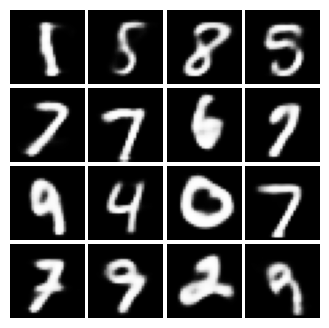

In [20]:
# set models to train mode
p.train()
q.train()
reparam.train()

parameters = list(p.parameters()) + list(q.parameters())
optim = torch.optim.Adam(parameters, lr=learning_rate, betas=(0.5, 0.999))
bce = nn.BCELoss(size_average=False, reduction='mean')

total_losses = []
recon_losses = []
kl_losses = []
current_image = 0

print('Training...')
for epoch in range(max_epochs):

  avg_total_loss = 0
  avg_recon_loss = 0
  avg_kl_loss = 0

  for _, (batch, _) in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch}")):
    batch = batch.to(device) # load the data onto GPU is relevant
    batch = batch.view(batch_size, -1)

    # forward
    z_mu, z_var = q(batch)
    z = reparam(z_mu, z_var)
    batch_recon = p(z)

    # reconstruction loss E[log P(X|z)]
    recon_loss = bce(batch_recon, batch) / len(batch)
    # distribution loss D_KL(Q(z|X) || P(z))
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_var) + z_mu ** 2 - 1. - z_var, 1))
    # Total loss
    total_loss = recon_loss + kl_loss

    # backward
    total_loss.backward()

    # update
    optim.step()

    # housekeeping
    optim.zero_grad()
    avg_total_loss += total_loss / len(batch)
    avg_recon_loss += recon_loss / len(batch)
    avg_kl_loss += kl_loss / len(batch)

  # end of epoch
  total_losses.append(avg_total_loss.item())
  recon_losses.append(avg_recon_loss.item())
  kl_losses.append(avg_kl_loss.item())
  print(f"\t[Losses] Total {total_losses[-1]:.3} - Recon. {recon_losses[-1]:.3} - KL {kl_losses[-1]:.3}")

  # plot
  if epoch % 2 == 0:
        samples = p(z).data.cpu().numpy()[:16]

        plt.close()
        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        if not os.path.exists('training/'):
            os.makedirs('out/')
        # plt.show()
        # plt.pause(0.1)
        plt.savefig('training/{}_{}.png'.format(epoch, str(current_image).zfill(3)), bbox_inches='tight')
        current_image += 1
        # plt.close(fig)

print("Done.")

We can now plot the training curves.

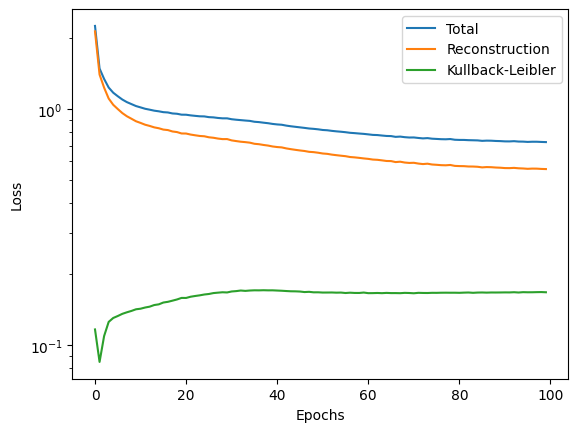

In [21]:
plt.ion()

fig = plt.figure()
plt.semilogy(total_losses, label='Total')
plt.semilogy(recon_losses, label='Reconstruction')
plt.semilogy(kl_losses, label='Kullback-Leibler')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Generation
----------

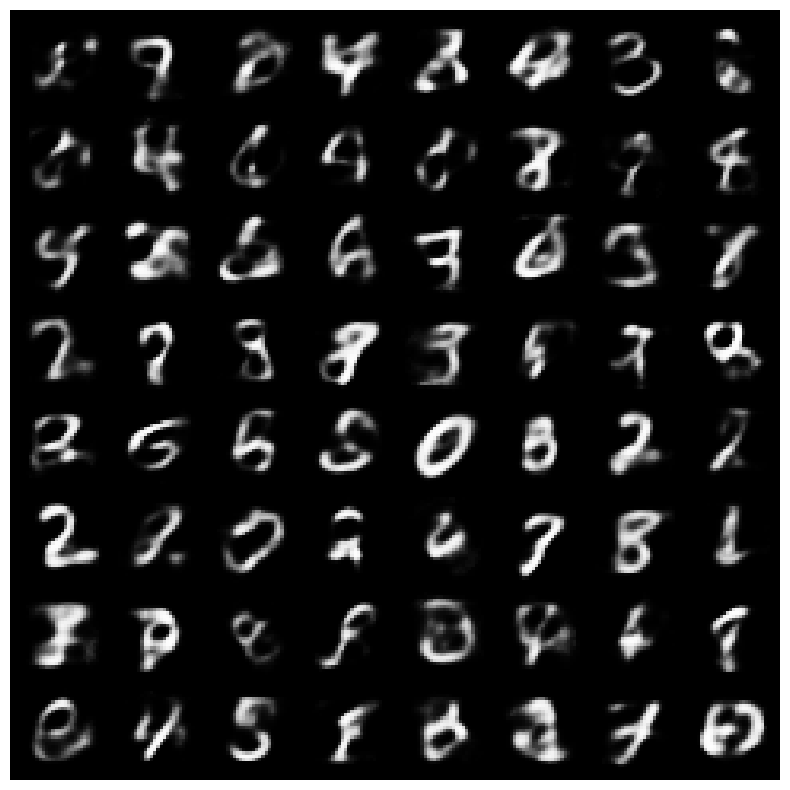

In [22]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()
n = 8

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def correct_shape(imgs):
  return imgs.view(n**2, 28, 28).unsqueeze(1)

with torch.no_grad():
    # sample latent vectors from the standard normal distribution
    latent = torch.randn((n**2, latent_dim), device=device)
    fake_image_batch = p(latent)
    fake_image_batch = correct_shape(fake_image_batch)
    fake_image_batch = fake_image_batch.cpu()


    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(fake_image_batch.data,nrow=n))
    plt.axis('off')
    plt.show()

Visualization in Latent Space
-----------------------------

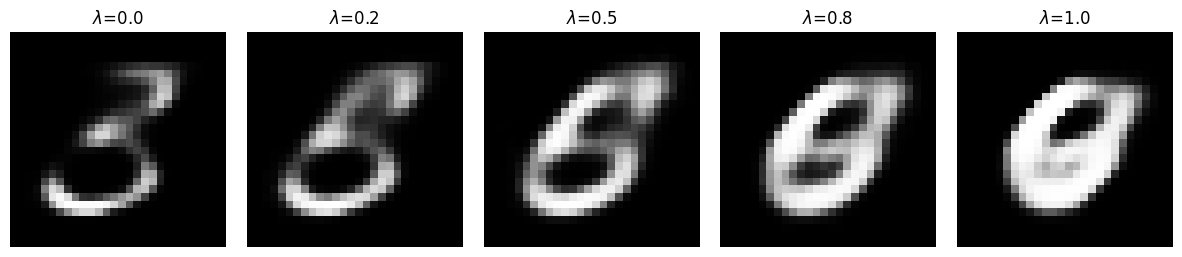

In [23]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

p.eval()

def correct_shape(imgs):
  return imgs.view(-1, 28, 28).unsqueeze(1)

def interpolation(lambda1, model, latent_1, latent_2):

    with torch.no_grad():

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_latent = inter_latent.to(device)
        inter_image = model(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image

# sample two latent vectors from the standard normal distribution
latent_1 = torch.randn((1, latent_dim), device=device)
latent_2 = torch.randn((1, latent_dim), device=device)

# interpolation lambdas
lambda_range=np.linspace(0,1,5)

fig, axs = plt.subplots(1,5, figsize=(15, 3))
fig.subplots_adjust(wspace=.1)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), p, latent_1, latent_2)

    inter_image = correct_shape(inter_image)

    image = inter_image.numpy()

    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('$\lambda$='+str(round(l,1)))
    axs[ind].axis('off')
plt.show()